In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

% matplotlib inline

data = pd.read_csv("data/train_clean.csv")
data.head()

,longitude,latitude,lithology,bathymetry,nitrate,oxygen,phosphate,productivity,salinity,silicate,temperature
0,-180,75,4,-231.0,NaN,8.552258,NaN,310.199677,31.165499,NaN,-0.878415
1,-179,75,4,-203.0,1.702168,9.494461,0.754516,312.468658,29.931450,12.485500,-1.785413
2,-178,75,4,-304.0,1.850258,9.578869,0.735949,291.436279,30.048571,12.902109,-1.904204
3,-177,75,4,-278.0,1.960688,9.668440,0.720070,277.305817,30.211161,13.251008,-1.869162
4,-176,75,4,-247.0,2.056301,9.763065,0.706926,262.947571,30.398439,13.591722,-1.688048


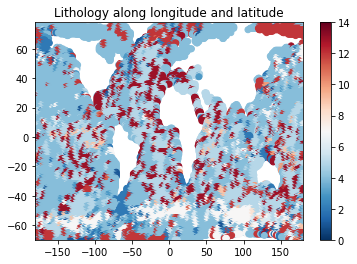

In [2]:
lon = data["longitude"].values
lat = data["latitude"].values
y = data["lithology"].values


# plot lithology vesus longitude and latitude
def draw_gloabl(lon, lat, y, title, cmap="RdBu_r", vmin=0, vmax=14):
    sc = plt.scatter(lon, lat, c=y, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.xlim([-180, 180])
    plt.ylim([-70, 78])
    plt.colorbar(sc)
    plt.show()
    
draw_gloabl(lon, lat, y, "Lithology along longitude and latitude")

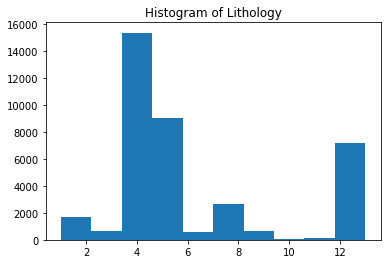

Unique class = [ 1  2  3  4  5  6  7  8  9 10 11 12 13]


In [3]:
# plot the histogram of lithology
plt.hist(y)
plt.title("Histogram of Lithology")
plt.show()
print("Unique class = {}".format(np.unique(y)))

### One-vs-all

Build 13 classifier such that

$$h_\theta^{(i)}(x) = P(y=i|x; \theta) \quad (i=1, 2, ..., 13)$$

Train a logistic regression classifier $h_\theta^{(i)}(x)$ for each class $i$ to predict the probability that $y=i$.

On a new input $x$, to make a prediction, pick the class i that maximizes
$$max_{i} h_\theta^{(i)}(x)$$

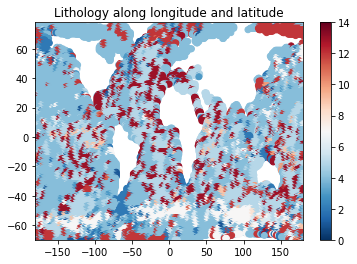

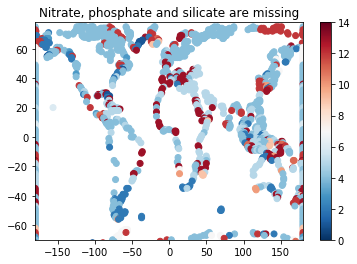

In [7]:
# training data should exclude longitude and latitude
training_data = data.copy()
del training_data["longitude"]
del training_data["latitude"]
training_data.head()

# feature missing reports
# for col in training_data:
#     missing = sum(pd.isnull(training_data[col]))
#     print("Missing Count in {} = {}".format(col, missing))
    

# check missing are consistent
nitrate_missing = pd.isnull(training_data["nitrate"])
phosphate_missing = pd.isnull(training_data["phosphate"])
silicate_missing = pd.isnull(training_data["silicate"])
assert np.array_equal(nitrate_missing, phosphate_missing)
assert np.array_equal(nitrate_missing, silicate_missing)


# global map including and excluding missing parts
draw_gloabl(lon, lat, y, "Lithology along longitude and latitude")
# highlight place of missing
draw_gloabl(lon[nitrate_missing],
            lat[nitrate_missing],
            y[nitrate_missing], 
            "Nitrate, phosphate and silicate are missing")

In [5]:
# obtain list of feature names
target = "lithology"
features = list(training_data.columns)
features.remove(target)

# impute missing with mean
fill_dict = {}
for col in training_data:
    fill_dict[col] = np.mean(training_data[col])
training_data = training_data.fillna(value=fill_dict)

# construct X and y 
X = training_data[features].as_matrix()
y = training_data[target].as_matrix()

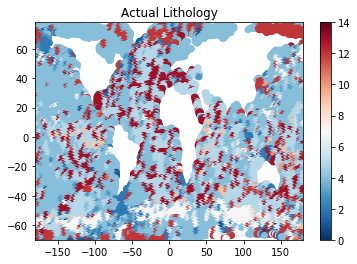

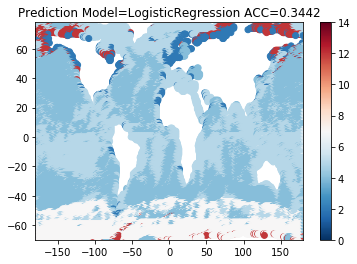

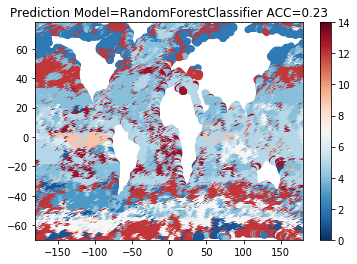

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score

def validate(classifier, name):
    """Validate with given classifier."""
    prediction = cross_val_predict(classifier, X, y, cv=3)
    acc = round(accuracy_score(y, prediction), 4)
    title = "Prediction Model={} ACC={}".format(name, acc)
    draw_gloabl(lon, lat, prediction, title)

# different classifiers
logistic = LogisticRegression()
rfc = RandomForestClassifier()
gpc = GaussianProcessClassifier()

# cross validation
draw_gloabl(lon, lat, y, "Actual Lithology")
validate(logistic, "LogisticRegression")
validate(rfc, "RandomForestClassifier")
# validate(gpc, "GaussianProcess")

In [16]:
# use Glabrezu
from dretch.io import load_modron
import glabrezu as gl

mod = load_modron("data/data.mod")
train_value = mod["train"].values()

transformer = [gl.transforms.FillOrdinals(),
               gl.transforms.ScaleFloats()]

models = {
    "Logistic": gl.Pipeline(transformer,
                            gl.classifiers.Logistic())
}
m = models["Logistic"]

train_ind, test_ind = train_test_split(range(len(train_value)),
                                       test_size=0.2)

instance = gl.train(m, train_value[train_ind])
result = gl.predict(m, train_value[test_ind])

NotImplementedError: Could not find signature for predict: <Pipeline, OrdinalValues, bool>